In [2]:
# Using the compressed dog images to try and build a variational autoencoder

In [1]:
#imports
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory

In [22]:
#Fixing right tensorflow version
!pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 24 kB/s 
     |████████████████████████████████| 463 kB 4.9 MB/s 
     |████████████████████████████████| 1.3 MB 60.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


In [2]:
#checking gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
#Mounting drive and unzipping the images

if not os.path.exists('images_similar'):
  from google.colab import drive
  drive.mount('/content/drive')
  !unzip drive/MyDrive/images_compressed.zip

Mounted at /content/drive


In [ ]:
#Hyperparameter
dirname = "./images_compressed"
batch_size = 128
EPOCHS = 30
image_sizes = (256,256,1)

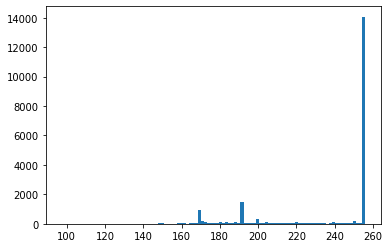

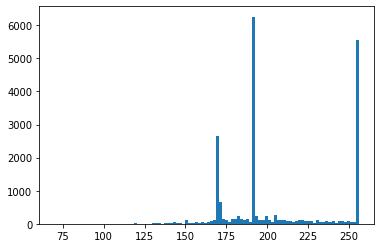

In [4]:
#Going through all images looking at size
x_sizes = []
y_sizes = []

for root, dirs, files in os.walk(dirname):
    for name in [file for file in files if ".jpg" in file]:
        im = Image.open(os.path.join(root,name))
        x_sizes.append(im.size[0])
        y_sizes.append(im.size[1])

plt.figure()
plt.hist(x_sizes, bins=100)
plt.show()
plt.figure()
plt.hist(y_sizes, bins=100)
plt.show()

In [5]:
#Investigating a single image
im.show()
im_array = np.asarray(im)
print(np.max(im_array), np.min(im_array))

print(im.size)

250 10
(256, 256)


In [7]:
#Using dataset from directory

train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1337,
  color_mode='grayscale',
  image_size=image_sizes[:2],
  batch_size=batch_size,
  labels = None)

Found 20580 files belonging to 1 classes.
Using 16464 files for training.


In [8]:
#Validationg data
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1337,
  color_mode='grayscale',
  image_size=image_sizes[:2],
  batch_size=batch_size,
  labels = None)

Found 20580 files belonging to 1 classes.
Using 4116 files for validation.


(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


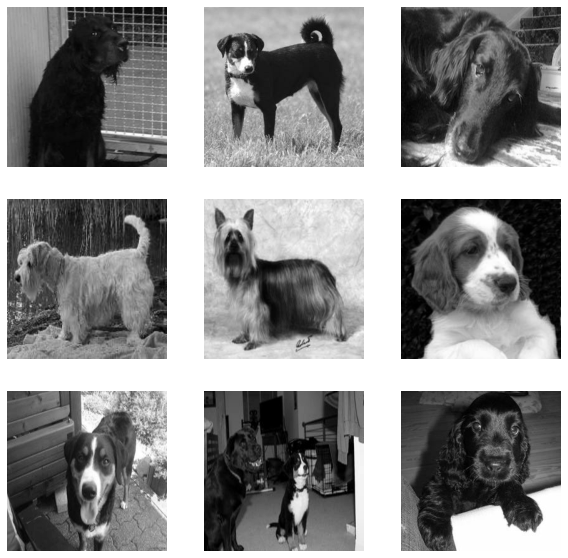

In [9]:
#Visualizing a couple
plt.figure(figsize=(10,10))
for images in train_ds.take(1):
    for i in range(9):
        print(images[i].shape)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")), cmap = "gray")
        plt.axis("off")

In [10]:
#Sampling custom layer
class Sampling(layers.Layer):
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

In [31]:
# Encoder and Decoder

#Encoder
latent_dim = 500
encoder_inputs = layers.Input(shape=image_sizes)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.MaxPooling2D(2, padding = "same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPooling2D(2, padding = "same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPooling2D(2, padding = "same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 64)  0           ['conv2d_6[0][0]']               
                                                                                            

In [33]:
#Decoder

latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(4*4*64, activation = 'relu')(latent_inputs)
x = layers.Reshape((4,4,64))(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              513024    
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 up_sampling2d_9 (UpSampling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 16, 16, 64)       36928     
 Transpose)                                                      
                                                                 
 up_sampling2d_10 (UpSamplin  (None, 32, 32, 64)       0   

In [34]:
# VAE class

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean()
        
    @property
    def metrics(self):
        return [self.total_loss_tracker]
    
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            data = layers.Rescaling(1./255)(data)
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data,reconstruction), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.total_loss_tracker.result()
        }

    def call(self, inputs):
      inputs = layers.Rescaling(1./255)(inputs)
      _, _, z = self.encoder(inputs)
      reconstruction = self.decoder(z)
      return reconstruction

In [ ]:
#Training the model

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(train_ds,
        validation_data = val_ds,
        epochs=EPOCHS)

Epoch 1/30
129/129 [==============================] - 112s 809ms/step - loss: 44673.4435 - val_mean: 0.0000e+00
Epoch 2/30
129/129 [==============================] - 102s 786ms/step - loss: 42517.8555 - val_mean: 0.0000e+00
Epoch 3/30
129/129 [==============================] - 102s 782ms/step - loss: 41685.2957 - val_mean: 0.0000e+00
Epoch 4/30
129/129 [==============================] - 99s 765ms/step - loss: 41623.5044 - val_mean: 0.0000e+00
Epoch 5/30
129/129 [==============================] - 99s 763ms/step - loss: 41490.6466 - val_mean: 0.0000e+00
Epoch 6/30
129/129 [==============================] - 99s 762ms/step - loss: 41401.1363 - val_mean: 0.0000e+00
Epoch 7/30
129/129 [==============================] - 100s 773ms/step - loss: 41362.3941 - val_mean: 0.0000e+00
Epoch 8/30
129/129 [==============================] - 101s 781ms/step - loss: 41333.6768 - val_mean: 0.0000e+00
Epoch 9/30
129/129 [==============================] - 102s 784ms/step - loss: 41316.3480 - val_mean: 0.0000

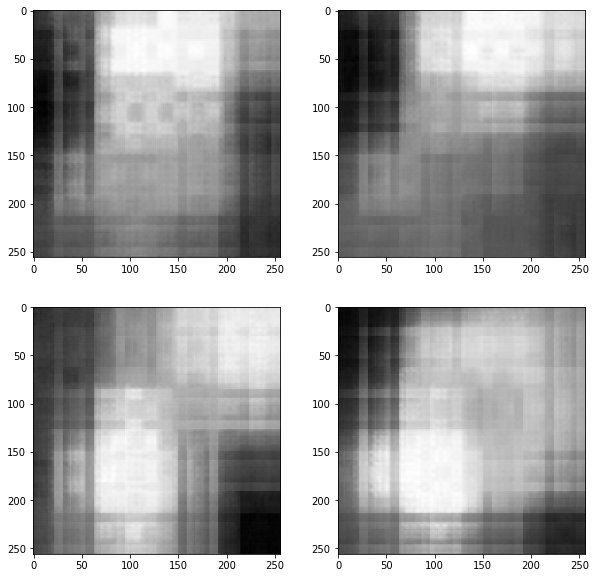

In [27]:
#Inspecting results
n = 4

plt.figure(figsize=(10,10))
for i in range(n):
  z_draft = np.random.rand(1,10)
  currim = vae.decoder(z_draft)
  currim = currim*255
  currim = currim.numpy().astype("uint8")
  currim = np.squeeze(currim)
  ax = plt.subplot(2,2,i+1)
  plt.imshow(currim, cmap="gray")
